**Importing necessary libraries**

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec 13 23:30:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    53W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import files
import time
import os
import glob
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.core.pylabtools import figsize

import torch
import torchvision
from torchvision import datasets, transforms,models
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights, densenet121, DenseNet121_Weights
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)


Mounted at /content/drive


**Structuring the dataset -- This is a one time thing. **

In [5]:
# ALL DONE



# !mkdir -p /content/drive/MyDrive/Machine\ Learning\ project/resnet/data/
dat_dir = '/content/drive/MyDrive/Machine Learning project/resnet/data'
working_dir = '/content/drive/MyDrive/Machine Learning project/resnet'
dataset_dir = '/content/drive/MyDrive/Machine Learning project/Balanced_training_set/Balanced'

training_dir = os.path.join(dat_dir, "training")
# if not os.path.isdir(training_dir):
#   os.mkdir(training_dir)

CE_training_dir = os.path.join(training_dir,"CE")
# if not os.path.isdir(CE_training_dir):
#   os.mkdir(CE_training_dir)

LAA_training_dir = os.path.join(training_dir,"LAA")
# if not os.path.isdir(LAA_training_dir):
#   os.mkdir(LAA_training_dir)

testing_dir = os.path.join(dat_dir, "testing")
# if not os.path.isdir(testing_dir):
#   os.mkdir(testing_dir)

CE_testing_dir = os.path.join(testing_dir,"CE")
# if not os.path.isdir(CE_testing_dir):
#   os.mkdir(CE_testing_dir)

LAA_testing_dir = os.path.join(testing_dir,"LAA")
# if not os.path.isdir(LAA_testing_dir):
#   os.mkdir(LAA_testing_dir)




Next Step is to populate the train and the test folders with the respective data

In [6]:
# csv_path = os.path.join(dataset_dir,"balanced_training_data.csv")
# df_train = pd.read_csv(csv_path)
# df_train.dropna(how="all", inplace=True)
# # display(df_train.head())
# # 2086523
# i = 0 
# for _, row in df_train.iterrows():
#   p_img = os.path.join(dataset_dir, "balanced_train", f"{row['image_id']}")
#   # print(p_img)
#   if not os.path.isfile(p_img):
#     print(f"missing: {p_img}")
#     continue
#   # shutil.copy(p_img, os.path.join(training_dir, row["label"], f"{row['image_id']}"))
#   i+=1
#   # print(f'{i/2086*100 } %  training data copied')

# csv_path = os.path.join(dataset_dir,"balanced_testing_data.csv")
# df_test = pd.read_csv(csv_path)
# df_test.dropna(how="all", inplace=True)
# i = 0
# for _, row in df_test.iterrows():
#   p_img = os.path.join(dataset_dir, "balanced_test", f"{row['image_id']}")
#   # print(p_img)
#   if not os.path.isfile(p_img):
#     print(f"missing: {p_img}")
#     continue
#   # shutil.copy(p_img, os.path.join(testing_dir, row["label"], f"{row['image_id']}"))
#   i+=1
#   # print(f'{i/523*100 } %  testing data copied')



In [7]:
count = 0
for root_dir, cur_dir, files in os.walk(training_dir):
    count += len(files)
print('training examples :', count)
count = 0
for root_dir, cur_dir, files in os.walk(testing_dir):
    count += len(files)
print('testing examples :', count)

training examples : 2085
testing examples : 522


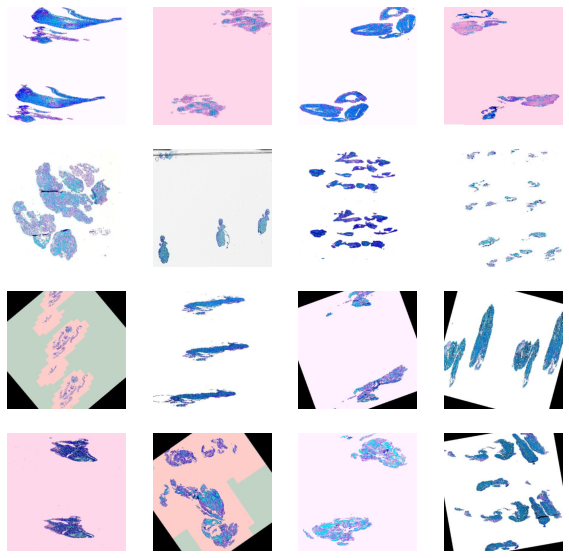

In [8]:
samples_CE = [os.path.join(CE_training_dir,np.random.choice(os.listdir(CE_training_dir),1)[0]) for _ in range(8)]
samples_LAA = [os.path.join(LAA_training_dir,np.random.choice(os.listdir(LAA_training_dir),1)[0]) for _ in range(8)]

nrows = 4
ncols = 4

fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
ax = ax.flatten()

for i in range(nrows*ncols):
  if i < 8:
    pic = plt.imread(samples_CE[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
  else:
    pic = plt.imread(samples_LAA[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
plt.show()

In [9]:
traindir = training_dir
testdir = testing_dir

train_transforms = transforms.Compose([
                                        # transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        torchvision.transforms.Normalize(
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
                                          ),
                                          ]
                                      )
test_transforms = transforms.Compose([
                                        # transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        torchvision.transforms.Normalize(
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
                                          ),
                                          ]
                                      )

train_data = datasets.ImageFolder(traindir,transform=train_transforms)
test_data = datasets.ImageFolder(testdir,transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=5)
testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=5)


In [10]:
def make_train_step(model, optimizer, loss_fn):
  def train_step(x,y):
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss
    loss = loss_fn(yhat,y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #optimizer.cleargrads()

    return loss
  return train_step


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.densenet121(DenseNet121_Weights.DEFAULT)
print(model)

for params in model.parameters():
  params.requires_grad_ = False

#add a new final layer
nr_filters = model.classifier.in_features  #number of input features of last layer
#model.fc = nn.Linear(nr_filters, 1) ----->>>> reedit and previous line .fc -> .classifier
model.classifier = nn.Linear(nr_filters, 1)

model = model.to(device)

loss_fn = BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model

#optimizer
#optimizer = torch.optim.Adam(model.fc.parameters()) 
optimizer = torch.optim.Adam(model.classifier.parameters()) 
#train step
train_step = make_train_step(model, optimizer, loss_fn)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# %%capture
# !pip install tqdm
from tqdm import tqdm


losses = []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []

n_epochs = 20
early_stopping_tolerance = 3
early_stopping_threshold = 0.03

for epoch in range(n_epochs):
  epoch_loss = 0
  for i ,data in tqdm(enumerate(trainloader), total = len(trainloader)): #iterate ove batches
    x_batch , y_batch = data
  
    x_batch = x_batch.to(device) #move to gpu

    y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape

    y_batch = y_batch.to(device) #move to gpu

    loss = train_step(x_batch, y_batch)
    epoch_loss += loss/len(trainloader)
    losses.append(loss)
    
  epoch_train_losses.append(epoch_loss)
  print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

  #validation doesnt requires gradient
  with torch.no_grad():
    cum_loss = 0
    for x_batch, y_batch in testloader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to(device)

      #model to eval mode
      model.eval()

      yhat = model(x_batch)
      val_loss = loss_fn(yhat,y_batch)
      cum_loss += loss/len(testloader)
      val_losses.append(val_loss.item())


    epoch_test_losses.append(cum_loss)
    print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))  
    
    best_loss = min(epoch_test_losses)
    
    #save best model
    if cum_loss <= best_loss:
      best_model_wts = model.state_dict()
    
    #early stopping
    early_stopping_counter = 0
    if cum_loss > best_loss:
      early_stopping_counter +=1

    if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
      print("/nTerminating: early stopping")
      break #terminate training
    
#load best model
model.load_state_dict(best_model_wts)


100%|██████████| 417/417 [03:50<00:00,  1.81it/s]



Epoch : 1, train loss : 0.6356712579727173
Epoch : 1, val loss : 0.6599894165992737


100%|██████████| 417/417 [00:45<00:00,  9.13it/s]



Epoch : 2, train loss : 0.5938092470169067
Epoch : 2, val loss : 0.3901863694190979


100%|██████████| 417/417 [00:45<00:00,  9.19it/s]



Epoch : 3, train loss : 0.5663026571273804
Epoch : 3, val loss : 1.4745404720306396


100%|██████████| 417/417 [00:45<00:00,  9.23it/s]



Epoch : 4, train loss : 0.5632748603820801
Epoch : 4, val loss : 0.3987657427787781


100%|██████████| 417/417 [00:45<00:00,  9.17it/s]



Epoch : 5, train loss : 0.5489967465400696
Epoch : 5, val loss : 0.6276447772979736


100%|██████████| 417/417 [00:45<00:00,  9.12it/s]



Epoch : 6, train loss : 0.5410054326057434
Epoch : 6, val loss : 0.424542099237442


100%|██████████| 417/417 [00:45<00:00,  9.17it/s]



Epoch : 7, train loss : 0.5437201261520386
Epoch : 7, val loss : 0.37253105640411377


100%|██████████| 417/417 [00:45<00:00,  9.19it/s]



Epoch : 8, train loss : 0.5479338765144348
Epoch : 8, val loss : 0.5543335676193237


100%|██████████| 417/417 [00:45<00:00,  9.22it/s]



Epoch : 9, train loss : 0.5321422815322876
Epoch : 9, val loss : 0.5521733164787292


100%|██████████| 417/417 [00:45<00:00,  9.22it/s]



Epoch : 10, train loss : 0.5381311178207397
Epoch : 10, val loss : 0.5683826208114624


100%|██████████| 417/417 [00:45<00:00,  9.18it/s]



Epoch : 11, train loss : 0.52588951587677
Epoch : 11, val loss : 0.2595927119255066


100%|██████████| 417/417 [00:45<00:00,  9.27it/s]



Epoch : 12, train loss : 0.5267909169197083
Epoch : 12, val loss : 0.8014788031578064


100%|██████████| 417/417 [00:45<00:00,  9.18it/s]



Epoch : 13, train loss : 0.5248987078666687
Epoch : 13, val loss : 0.523851215839386


100%|██████████| 417/417 [00:45<00:00,  9.23it/s]



Epoch : 14, train loss : 0.5273483991622925
Epoch : 14, val loss : 0.36114203929901123


100%|██████████| 417/417 [00:45<00:00,  9.12it/s]



Epoch : 15, train loss : 0.5356537103652954
Epoch : 15, val loss : 0.668794572353363


100%|██████████| 417/417 [00:45<00:00,  9.08it/s]



Epoch : 16, train loss : 0.5052720308303833
Epoch : 16, val loss : 0.6659324765205383


100%|██████████| 417/417 [00:46<00:00,  9.06it/s]



Epoch : 17, train loss : 0.5123547911643982
Epoch : 17, val loss : 0.19489872455596924


100%|██████████| 417/417 [00:46<00:00,  9.05it/s]



Epoch : 18, train loss : 0.5162222981452942
Epoch : 18, val loss : 0.39840903878211975


100%|██████████| 417/417 [00:46<00:00,  9.06it/s]



Epoch : 19, train loss : 0.49053558707237244
Epoch : 19, val loss : 0.2820655405521393


100%|██████████| 417/417 [00:46<00:00,  9.05it/s]



Epoch : 20, train loss : 0.5232115983963013
Epoch : 20, val loss : 0.26830899715423584


<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt 

def inference(test_data):
  y_pred = list()
  y_test = list()
  for i,image in enumerate(test_data):
    label = test_data[i][1]
    # print(label)
    y_test.append(label)
    sample  = torch.unsqueeze(image[0], dim=0).to(device)
    if torch.sigmoid(model(sample)) < 0.5:
      y_pred.append(0)
      
      # print("Prediction : 0")
    else:
      y_pred.append(1)
      # print("Prediction : 1")
    # print()
  return y_pred,y_test
      
  # idx = torch.randint(1, len(test_data), (1,))
  # sample = torch.unsqueeze(test_data[idx][0], dim=0).to(device)
  # print(sample)

  # if torch.sigmoid(model(sample)) < 0.5:
  #   print("Prediction : LAA")
  # else:
  #   print("Prediction : CE")


  # plt.imshow(test_data[idx][0].permute(1, 2, 0))

y_pred, y_test = inference(test_data)
# for i in range(len (y_pred)):
#   print(y_pred[i],"\t", y_test[i])

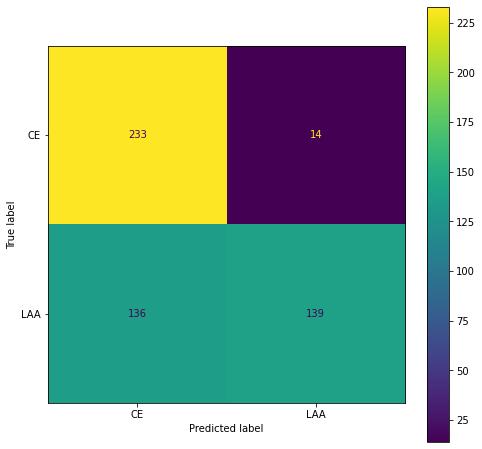

accuracy:  0.7126436781609196
AUC:  0.7243871917556127


In [ ]:
# def class_report(y_pred, treshold):
#   y_pred = np.array(y_pred)
#   y_pred_binary = np.where(y_pred > treshold, 1,0)
#   print(classification_report(y_test, y_pred_binary))

#   return y_pred_binary
# Function to plot a confusion matrix of the test data, with CE = 0 and LAA = 1
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sklearn
def conf_matrix(y_test, y_pred_binary):
  cm = confusion_matrix(y_test, y_pred_binary)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['CE', 'LAA'])
  fig, ax = plt.subplots(figsize=(8,8))
  disp.plot(ax=ax)
  plt.show()

conf_matrix(y_test, y_pred)
print("accuracy: ",sklearn.metrics.accuracy_score(y_test,y_pred))
print("AUC: " , sklearn.metrics.roc_auc_score(y_test, y_pred))


In [ ]:
print("F1: ", sklearn.metrics.f1_score(y_test, y_pred))